In [1]:
import numpy as np
import argparse
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from std_msgs.msg import String
import scipy.spatial.transform
import rosbag2_py
import pickle
import matplotlib.pyplot as plt

In [2]:
pose_dtype = [('t', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8'), ('qw', 'f8'), ('qx', 'f8'), ('qy', 'f8'), ('qz', 'f8')]
uwb_dtype = [('t', 'f8'), ('status', 'u4'), ('distance', 'i8'), ('aoa_elevation', 'f8'), ('aoa_azimuth', 'f8'), ('nlos', 'u8')]

uwb_anchor_dtype = [('t', 'f8'), ('measurements', 'u4'),
                    ('status0', 'u4'), ('distance0', 'i8'), ('aoa_elevation0', 'f8'), ('aoa_azimuth0', 'f8'), ('nlos0', 'u8'), ('mac_address0', 'u8'),
                    ('status1', 'u4'), ('distance1', 'i8'), ('aoa_elevation1', 'f8'), ('aoa_azimuth1', 'f8'), ('nlos1', 'u8'), ('mac_address1', 'u8')]
uwb_tag_dtype = [('t', 'f8'), ('measurements', 'u4'),
                 ('status0', 'u4'), ('initiator_responder_tof0', 'i8'), ('aoa_elevation0', 'f8'), ('aoa_azimuth0', 'f8'), ('nlos0', 'u8'), ('mac_address0', 'u8'),
                 ('status1', 'u4'), ('initiator_responder_tof1', 'i8'), ('aoa_elevation1', 'f8'), ('aoa_azimuth1', 'f8'), ('nlos1', 'u8'), ('mac_address1', 'u8'),
                 ('status2', 'u4'), ('initiator_responder_tof2', 'i8'), ('aoa_elevation2', 'f8'), ('aoa_azimuth2', 'f8'), ('nlos2', 'u8'), ('mac_address2', 'u8'),
                 ('status3', 'u4'), ('initiator_responder_tof3', 'i8'), ('aoa_elevation3', 'f8'), ('aoa_azimuth3', 'f8'), ('nlos3', 'u8'), ('mac_address3', 'u8')]

def read_messages(input_bag: str):
    reader = rosbag2_py.SequentialReader()
    reader.open(
        rosbag2_py.StorageOptions(uri=input_bag, storage_id="mcap"),
        rosbag2_py.ConverterOptions(
            input_serialization_format="cdr", output_serialization_format="cdr"
        ),
    )
    topic_types = reader.get_all_topics_and_types()

    def typename(topic_name):
        for topic_type in topic_types:
            if topic_type.name == topic_name:
                return topic_type.type
        raise ValueError(f"topic {topic_name} not in bag")

    while reader.has_next():
        topic, data, timestamp = reader.read_next()
        msg_type = get_message(typename(topic))
        msg = deserialize_message(data, msg_type)
        yield topic, msg, timestamp
    del reader


def q9_7_to_double(val):
    """https://github.com/microsoft/nearobject-framework/blob/3dc13b123391d177595863e67998ab565e06874a/lib/uwb/UwbPeer.cxx#L52"""
    signMask = 0b1000000000000000
    unsignedIntegerMask = 0b0111111110000000
    fractionMask = ~(signMask | unsignedIntegerMask)
    sign = val & signMask
    unsignedIntegerPart = (val & unsignedIntegerMask) >> 7
    fractionPart = val & fractionMask
    if sign:
       unsignedIntegerPart = (~unsignedIntegerPart + 1) & 0x00FF
    unsignedNumber = unsignedIntegerPart + fractionPart * 2**(-7)
    if sign:
        return unsignedNumber
    else:
        return -unsignedNumber


def process_uwb_twr_data(file):

    
    pose_topics = ['/rover/pose', '/uwb2/pose', '/uwb3/pose', '/uwb4/pose']
    uwb_topics = ['/sr1xx/twr_responder']
    all_topics = pose_topics + uwb_topics

    t0_stamp = None
    
    data_dict = {}
    for k in all_topics:
        data_dict[k] = []
    
    def store_pose(timestamp, msg):
        return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.pose.position.x, msg.pose.position.y, msg.pose.position.z,
                msg.pose.orientation.w, msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z)
    
    def store_uwb(timestamp, msg):
        return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.two_way_data[0].status,
                msg.two_way_data[0].distance,
                q9_7_to_double(np.array(msg.two_way_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.two_way_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.two_way_data[0].nlos)
    
    for topic, msg, timestamp in read_messages(file):
        if t0_stamp is None:
            t0_stamp = timestamp
        if topic in pose_topics:
            data_dict[topic].append(store_pose(timestamp, msg))
        elif topic in uwb_topics:
            data_dict[topic].append(store_uwb(timestamp, msg))
    
    data = {}
    for k in pose_topics:
        data[k] = np.array(data_dict[k], dtype=pose_dtype)
    for k in uwb_topics:
        data[k] = np.array(data_dict[k], dtype=uwb_dtype)
    return data

def process_uwb_dl_tdoa_data(file):

    
    pose_topics = ['/rover/pose', '/uwb2/pose', '/uwb3/pose', '/uwb4/pose']
    uwb_tag_topics = ['/sr1xx/tdoa_dl_tag']
    uwb_anchor_topics = ['/sr1xx/tdoa_dl_anchor_controlee',
                          '/sr1xx/tdoa_dl_anchor_controlee2',
                          '/sr1xx/tdoa_dl_anchor_controller']
    all_topics = pose_topics + uwb_anchor_topics + uwb_tag_topics

    t0_stamp = None
    
    data_dict = {}
    for k in all_topics:
        data_dict[k] = []
    
    def store_pose(timestamp, msg):
        return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.pose.position.x, msg.pose.position.y, msg.pose.position.z,
                msg.pose.orientation.w, msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z)
    
    def store_tag_uwb(timestamp, msg):
        if msg.measurements == 4:
            return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.measurements,
                msg.dl_tdoa_data[0].status,
                msg.dl_tdoa_data[0].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[0].nlos,
                msg.dl_tdoa_data[0].mac_address,
                msg.dl_tdoa_data[1].status,
                msg.dl_tdoa_data[1].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[1].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[1].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[1].nlos,
                msg.dl_tdoa_data[1].mac_address,
                msg.dl_tdoa_data[2].status,
                msg.dl_tdoa_data[2].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[2].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[2].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[2].nlos,
                msg.dl_tdoa_data[2].mac_address,
                msg.dl_tdoa_data[3].status,
                msg.dl_tdoa_data[3].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[3].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[3].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[3].nlos,
                msg.dl_tdoa_data[3].mac_address)
        elif msg.measurements == 3:
            return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.measurements,
                msg.dl_tdoa_data[0].status,
                msg.dl_tdoa_data[0].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[0].nlos,
                msg.dl_tdoa_data[0].mac_address,
                msg.dl_tdoa_data[1].status,
                msg.dl_tdoa_data[1].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[1].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[1].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[1].nlos,
                msg.dl_tdoa_data[1].mac_address,
                msg.dl_tdoa_data[2].status,
                msg.dl_tdoa_data[2].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[2].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[2].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[2].nlos,
                msg.dl_tdoa_data[2].mac_address,
                0,0,0.0,0.0,0,0)
        elif msg.measurements == 2:
            return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.measurements,
                msg.dl_tdoa_data[0].status,
                msg.dl_tdoa_data[0].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[0].nlos,
                msg.dl_tdoa_data[0].mac_address,
                msg.dl_tdoa_data[1].status,
                msg.dl_tdoa_data[1].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[1].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[1].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[1].nlos,
                msg.dl_tdoa_data[1].mac_address,
                msg.dl_tdoa_data[2].status,
                msg.dl_tdoa_data[2].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[2].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[2].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[2].nlos,
                msg.dl_tdoa_data[2].mac_address,
                0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0)
        elif msg.measurements == 1:
            return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.measurements,
                msg.dl_tdoa_data[0].status,
                msg.dl_tdoa_data[0].initiator_responder_tof,
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.dl_tdoa_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.dl_tdoa_data[0].nlos,
                msg.dl_tdoa_data[0].mac_address,
                0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0)
        else:
            print('something went wrong, tag measurements = {:d}'.format(msg.measurements))
            return((timestamp - t0_stamp)*1.0e-9,msg.measurements,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0)

    
    def store_anchor_uwb(timestamp, msg):
        if msg.measurements == 2:
            return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.measurements,
                msg.two_way_data[0].status,
                msg.two_way_data[0].distance,
                q9_7_to_double(np.array(msg.two_way_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.two_way_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.two_way_data[0].nlos,
                msg.two_way_data[0].mac_address,
                msg.two_way_data[1].status,
                msg.two_way_data[1].distance,
                q9_7_to_double(np.array(msg.two_way_data[1].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.two_way_data[1].aoa_azimuth, dtype=np.uint16)),
                msg.two_way_data[1].nlos,
                msg.two_way_data[1].mac_address)
        elif msg.measurements == 1:
            return (
                (timestamp - t0_stamp)*1.0e-9,
                msg.measurements,
                msg.two_way_data[0].status,
                msg.two_way_data[0].distance,
                q9_7_to_double(np.array(msg.two_way_data[0].aoa_elevation, dtype=np.uint16)),
                q9_7_to_double(np.array(msg.two_way_data[0].aoa_azimuth, dtype=np.uint16)),
                msg.two_way_data[0].nlos,
                msg.two_way_data[0].mac_address,
                0,0,0.0,0.0,0,0)
        else:
            print('something went wrong, anchor measurements = {:d}'.format(msg.measurements))
            return((timestamp - t0_stamp)*1.0e-9,msg.measurements,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0)
    
    for topic, msg, timestamp in read_messages(file):
        if t0_stamp is None:
            t0_stamp = timestamp
        if topic in pose_topics:
            data_dict[topic].append(store_pose(timestamp, msg))
        elif topic in uwb_anchor_topics:
            data_dict[topic].append(store_anchor_uwb(timestamp, msg))
        elif topic in uwb_tag_topics:
            data_dict[topic].append(store_tag_uwb(timestamp, msg))
    
    data = {}
    for k in pose_topics:
        data[k] = np.array(data_dict[k], dtype=pose_dtype)
    for k in uwb_anchor_topics:
        data[k] = np.array(data_dict[k], dtype=uwb_anchor_dtype)
    for k in uwb_tag_topics:
        data[k] = np.array(data_dict[k], dtype=uwb_tag_dtype)
    return data


def transform_pose(p_u, p_r):
    """
    frames
    w: world
    u: uwb sensor
    r: rover

    p_u : (R_wu, vu_w)
    p_r : (R_wr, vr_w)

    find:
    p_ur : (R_ur, vur_u)

    vur_u = R_wu^T (vr_w - vu_w)
    R_ur = R_wu^T * R_wr
    """
    Rwu = scipy.spatial.transform.Rotation.from_quat([p_u['qx'], p_u['qy'], p_u['qz'], p_u['qw']]).as_matrix()
    vu_w = np.array([p_u['px'], p_u['py'], p_u['pz']])

    Rwr = scipy.spatial.transform.Rotation.from_quat([p_r['qx'], p_r['qy'], p_r['qz'], p_r['qw']]).as_matrix()
    vr_w = np.array([p_r['px'], p_r['py'], p_r['pz']])

    Rur = Rwu.T@Rwr

    vur_u = Rwu.T @ (vr_w - vu_w)

    q3 = scipy.spatial.transform.Rotation.from_matrix(Rur).as_quat()
    p3 = np.hstack([p_r['t'], vur_u, q3]);

    return p3

def find_azim_elev(poses):
    euler = []
    for p in poses:
        q = np.array([p['qx'], p['qy'], p['qz'], p['qw']])
        R = scipy.spatial.transform.Rotation.from_quat(q)
        euler.append(R.as_euler(seq ='ZYX', degrees=True))
    return np.array(euler)

def time_slice_data(data, t0, tf):
    data_slice = {}
    for k in data.keys():
        mask = np.logical_and(data[k]['t'] >= t0 , data[k]['t'] <= tf)
        data_slice[k] = data[k][mask]
    return data_slice

def do_dl_tdoa_analysis(data):
    mask_ok = np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(data['/sr1xx/tdoa_dl_tag']['status0'] == 0,
                             data['/sr1xx/tdoa_dl_tag']['nlos0'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['status1'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['nlos1'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['status2'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['nlos2'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['status3'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['nlos3'] == 0),
                             data['/sr1xx/tdoa_dl_tag']['measurements'] == 4)
    p_trans = np.array([ tuple(transform_pose(data['/uwb2/pose'][0], p)) for p in data['/rover/pose'] ], dtype=pose_dtype)
    distance_ground_truth = np.linalg.norm(np.vstack([p_trans['px'], p_trans['py'], p_trans['pz']]), axis=0)
    azim_ground_truth = np.rad2deg(np.arctan2(p_trans['py'], p_trans['px']))
    dist_xy = np.linalg.norm(np.vstack([p_trans['px'], p_trans['py']]), axis=0)
    elev_ground_truth = np.rad2deg(np.arctan(p_trans['pz'], dist_xy))

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(data['/rover/pose']['px'], data['/rover/pose']['py'], '.', alpha=0.5, markersize=1)
    plt.plot(data['/uwb2/pose']['px'], data['/uwb2/pose']['py'], 'o', markersize=10, label='uwb2')
    plt.plot(data['/uwb3/pose']['px'], data['/uwb3/pose']['py'], 'o', markersize=10, label='uwb3')
    plt.plot(data['/uwb4/pose']['px'], data['/uwb4/pose']['py'], 'o', markersize=10, label='uwb4')
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.title('trajectory')

    plt.subplot(122)
    plt.plot(p_trans['t'], p_trans['px'], label='x')
    plt.plot(p_trans['t'], p_trans['py'], label='y')
    plt.plot(p_trans['t'], p_trans['pz'], label='z')
    plt.title('rover relative position')
    plt.xlabel('t, sec')
    plt.legend()
    plt.grid()
    
    uwb_2_4_d=np.average(np.sqrt(np.power(data['/uwb2/pose']['px'][0:10]-data['/uwb4/pose']['px'][0:10],2)
            + np.power(data['/uwb2/pose']['py'][0:10]-data['/uwb4/pose']['py'][0:10],2)
            + np.power(data['/uwb2/pose']['pz'][0:10]-data['/uwb4/pose']['pz'][0:10],2)))
    uwb_2_3_d=np.average(np.sqrt(np.power(data['/uwb2/pose']['px'][0:10]-data['/uwb3/pose']['px'][0:10],2)
            + np.power(data['/uwb2/pose']['py'][0:10]-data['/uwb3/pose']['py'][0:10],2)
            + np.power(data['/uwb2/pose']['pz'][0:10]-data['/uwb3/pose']['pz'][0:10],2)))
    
    plt.figure(figsize=(10, 5))
#     plt.plot(data['/sr1xx/tdoa_dl_tag']['t'][mask_ok], data['/sr1xx/tdoa_dl_tag']['initiator_responder_tof0'][mask_ok]/200, label='0')
    plt.plot(data['/sr1xx/tdoa_dl_tag']['t'][mask_ok], data['/sr1xx/tdoa_dl_tag']['initiator_responder_tof1'][mask_ok]/200-uwb_2_3_d, label='1')
    plt.plot(data['/sr1xx/tdoa_dl_tag']['t'][mask_ok], data['/sr1xx/tdoa_dl_tag']['initiator_responder_tof2'][mask_ok]/200-uwb_2_4_d, '.', label='2')
#     plt.plot(data['/uwb4/pose']['px'], data['/uwb4/pose']['py'], 'o', markersize=10, label='uwb4')
    plt.plot(data['/sr1xx/tdoa_dl_tag']['t'][mask_ok], data['/sr1xx/tdoa_dl_tag']['initiator_responder_tof3'][mask_ok]/200, label='3')
#     plt.plot(p_trans['t'][0:30000], uwb_2_4_d, label='uwb2_4')
#     plt.plot(p_trans['t'][0:30000], uwb_2_3_d, label='uwb2_3')
    plt.title('distance, m')
    plt.xlabel('t, sec')
    plt.legend()
    plt.grid()
    
#     plt.figure(figsize=(10, 5))
#     plt.plot(data['/sr1xx/twr_responder']['t'][mask_ok], data['/sr1xx/twr_responder']['aoa_elevation'][mask_ok], '.', label='uwb')
#     plt.plot(p_trans['t'], elev_ground_truth, label='ground truth')
#     plt.legend()
#     plt.title('elevation, deg')
#     plt.xlabel('t, sec')
#     plt.grid()

#     plt.figure(figsize=(10, 5))
#     plt.plot(data['/sr1xx/twr_responder']['t'][mask_ok], data['/sr1xx/twr_responder']['aoa_azimuth'][mask_ok], '.', label='uwb')
#     plt.plot(p_trans['t'], azim_ground_truth, label='ground truth')
#     plt.legend()
#     plt.title('azimuth, deg')
#     plt.xlabel('t, sec')
#     plt.grid()
    
def do_twr_analysis(data):
    mask_ok = np.logical_and(data['/sr1xx/twr_responder']['status'] == 0, data['/sr1xx/twr_responder']['nlos'] == 0)
    p_trans = np.array([ tuple(transform_pose(data['/uwb2/pose'][0], p)) for p in data['/rover/pose'] ], dtype=pose_dtype)
    distance_ground_truth = np.linalg.norm(np.vstack([p_trans['px'], p_trans['py'], p_trans['pz']]), axis=0)
    azim_ground_truth = np.rad2deg(np.arctan2(p_trans['py'], p_trans['px']))
    dist_xy = np.linalg.norm(np.vstack([p_trans['px'], p_trans['py']]), axis=0)
    elev_ground_truth = np.rad2deg(np.arctan(p_trans['pz'], dist_xy))

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(data['/rover/pose']['px'], data['/rover/pose']['py'], '.', alpha=0.5, markersize=1)
    plt.plot(data['/uwb2/pose']['px'], data['/uwb2/pose']['py'], 'o', markersize=10, label='uwb2')
    plt.plot(data['/uwb3/pose']['px'], data['/uwb3/pose']['py'], 'o', markersize=10, label='uwb3')
    plt.plot(data['/uwb4/pose']['px'], data['/uwb4/pose']['py'], 'o', markersize=10, label='uwb4')
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.title('trajectory')

    plt.subplot(122)
    plt.plot(p_trans['t'], p_trans['px'], label='x')
    plt.plot(p_trans['t'], p_trans['py'], label='y')
    plt.plot(p_trans['t'], p_trans['pz'], label='z')
    plt.title('rover relative position')
    plt.xlabel('t, sec')
    plt.legend()
    plt.grid()

    plt.figure(figsize=(10, 3))
    
    plt.subplot(121)
    plt.plot(data['/sr1xx/twr_responder']['t'], data['/sr1xx/twr_responder']['status'], label='status')
    plt.title('status')
    plt.xlabel('t, sec')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(data['/sr1xx/twr_responder']['t'], data['/sr1xx/twr_responder']['nlos'], label='nlos')
    plt.title('nlos')
    plt.xlabel('t, sec')
    plt.grid()
    
    plt.figure(figsize=(10, 5))
    plt.plot(data['/sr1xx/twr_responder']['t'][mask_ok], data['/sr1xx/twr_responder']['distance'][mask_ok]/100, '.', label='uwb')
    plt.plot(p_trans['t'], distance_ground_truth, label='ground truth')
    plt.title('distance, m')
    plt.xlabel('t, sec')
    plt.legend()
    plt.grid()
    
    plt.figure(figsize=(10, 5))
    plt.plot(data['/sr1xx/twr_responder']['t'][mask_ok], data['/sr1xx/twr_responder']['aoa_elevation'][mask_ok], '.', label='uwb')
    plt.plot(p_trans['t'], elev_ground_truth, label='ground truth')
    plt.legend()
    plt.title('elevation, deg')
    plt.xlabel('t, sec')
    plt.grid()

    plt.figure(figsize=(10, 5))
    plt.plot(data['/sr1xx/twr_responder']['t'][mask_ok], data['/sr1xx/twr_responder']['aoa_azimuth'][mask_ok], '.', label='uwb')
    plt.plot(p_trans['t'], azim_ground_truth, label='ground truth')
    plt.legend()
    plt.title('azimuth, deg')
    plt.xlabel('t, sec')
    plt.grid()

In [3]:
data = process_uwb_dl_tdoa_data('./rosbag2_2024_08_24-18_xx_bags_purt/rosbag2_2024_08_24-18_24_58/rosbag2_2024_08_24-18_24_58_0.mcap')
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something went wrong, tag measurements = 0
something w

In [ ]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
    
do_twr_analysis(time_slice_data(data, 0, 1000))

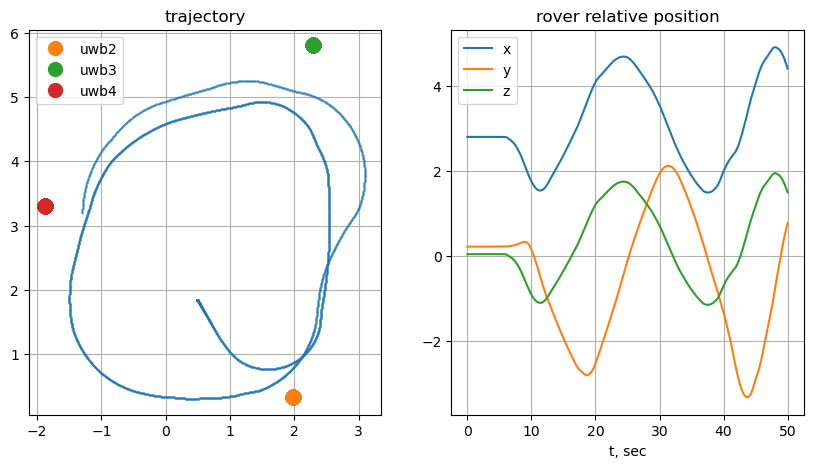

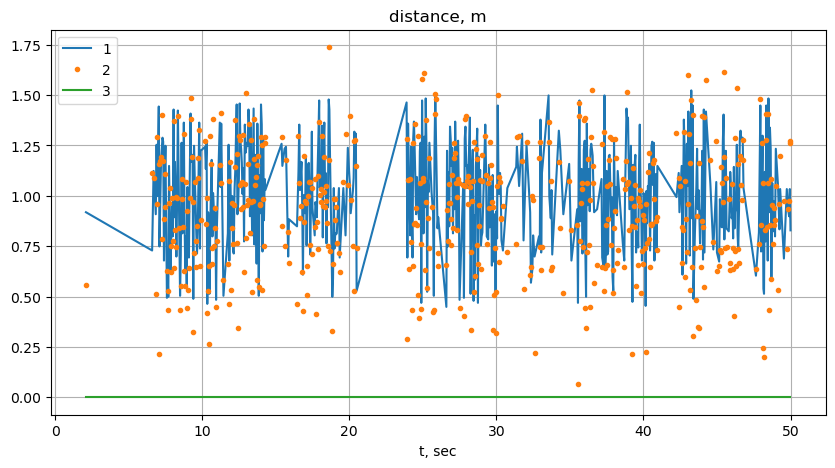

In [4]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
    
do_dl_tdoa_analysis(time_slice_data(data, 0, 50))